# 정규화 미적용

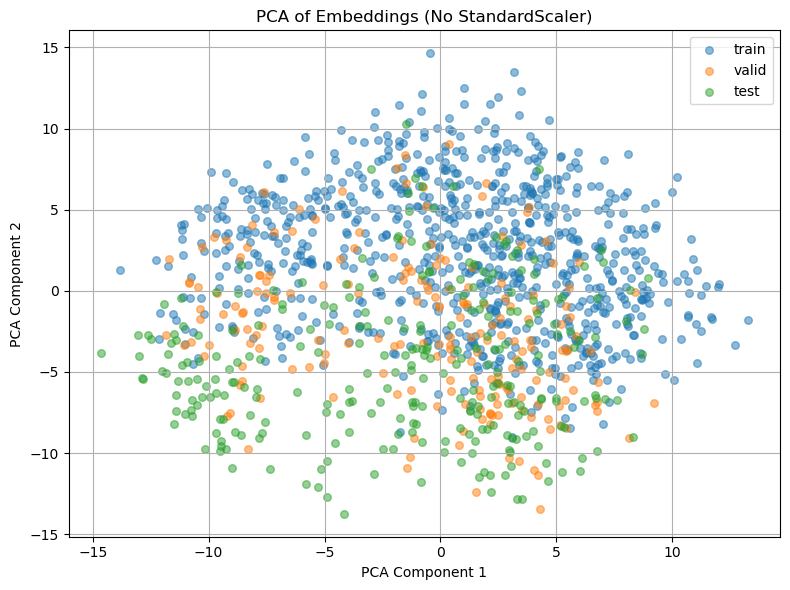

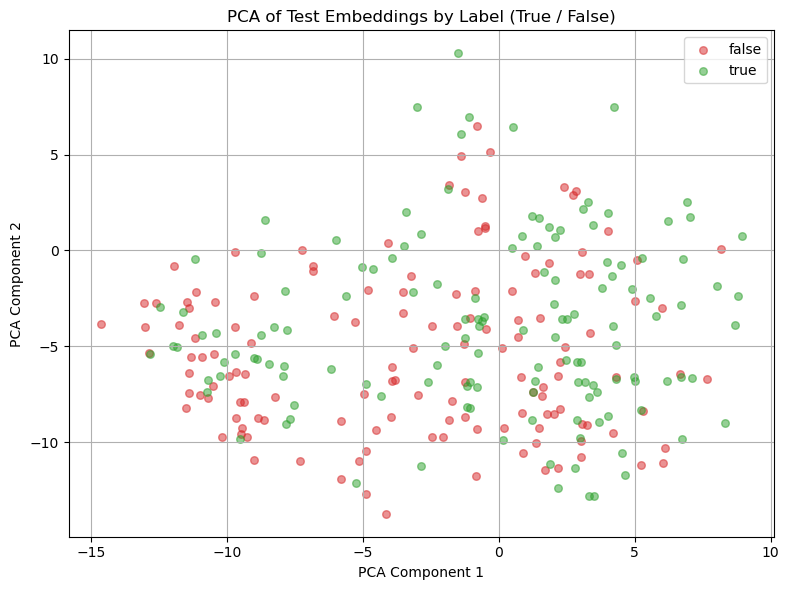

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# 설정
DATA_ROOT   = Path(r"D:\Jabez\golf\fusion\embbeding_data")
AGG_METHOD  = "max"  # "mean", "max", "flatten" 중 선택

def load_split(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

# 1. 데이터 불러오기
X_ts_tr, y_tr = load_split("train",   "timesformer")
X_st_tr, _    = load_split("train",   "stgcnpp")
X_ts_va, y_va = load_split("valid",   "timesformer")
X_st_va, _    = load_split("valid",   "stgcnpp")
X_ts_te, y_te = load_split("test",    "timesformer")
X_st_te, _    = load_split("test",    "stgcnpp")

# 2. ST-GCN 차원 축소
X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)
X_st_te = reduce_stgcn(X_st_te)

# 3. Concat (TS + ST), 정규화 없이 바로 결합
X_tr = np.concatenate([X_ts_tr, X_st_tr], axis=1)
X_va = np.concatenate([X_ts_va, X_st_va], axis=1)
X_te = np.concatenate([X_ts_te, X_st_te], axis=1)

# 4. PCA 수행
X_comb = np.vstack([X_tr, X_va, X_te])
y_comb = (
    ['train'] * len(X_tr) +
    ['valid'] * len(X_va) +
    ['test']  * len(X_te)
)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_comb)

# 5. 시각화
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, y in enumerate(y_comb) if y == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (No StandardScaler)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# test 데이터에서 label 기준으로 색 나눠 보기
X_te_comb = X_2d[-len(X_te):]
y_te_comb = y_te  # 0 = false, 1 = true

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_te_comb == label
    plt.scatter(X_te_comb[idx, 0], X_te_comb[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("PCA of Test Embeddings by Label (True / False)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# 정규화 적용

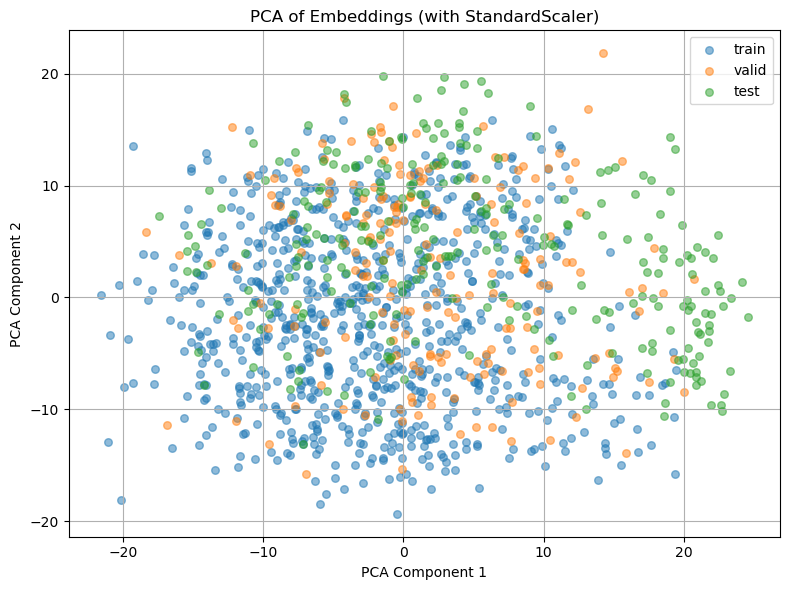

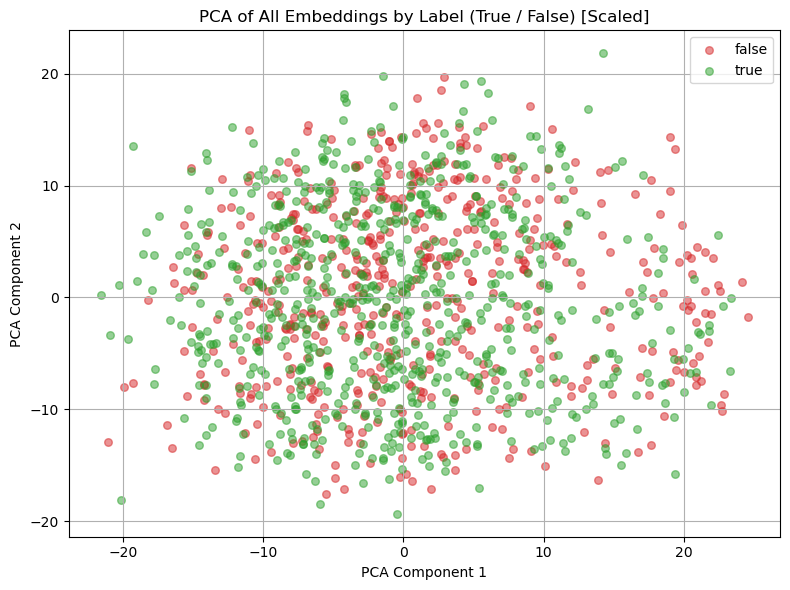

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# 설정
DATA_ROOT   = Path(r"D:\Jabez\golf\fusion\embbeding_data")
AGG_METHOD  = "max"  # "mean", "max", "flatten" 중 선택

def load_split(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

# 1. 데이터 불러오기
X_ts_tr, y_tr = load_split("train",   "timesformer")
X_st_tr, _    = load_split("train",   "stgcnpp")
X_ts_va, y_va = load_split("valid",   "timesformer")
X_st_va, _    = load_split("valid",   "stgcnpp")
X_ts_te, y_te = load_split("test",    "timesformer")
X_st_te, _    = load_split("test",    "stgcnpp")

# 2. ST-GCN 차원 축소
X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)
X_st_te = reduce_stgcn(X_st_te)

# 3. Concat (TS + ST)
X_tr = np.concatenate([X_ts_tr, X_st_tr], axis=1)
X_va = np.concatenate([X_ts_va, X_st_va], axis=1)
X_te = np.concatenate([X_ts_te, X_st_te], axis=1)

# 4. 정규화 (StandardScaler)
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))  # train+valid 기준으로 fit
X_tr_scaled = scaler.transform(X_tr)
X_va_scaled = scaler.transform(X_va)
X_te_scaled = scaler.transform(X_te)

# 5. PCA
X_all_scaled = np.vstack([X_tr_scaled, X_va_scaled, X_te_scaled])
y_all_split  = (
    ['train'] * len(X_tr_scaled) +
    ['valid'] * len(X_va_scaled) +
    ['test']  * len(X_te_scaled)
)
y_all_label  = np.concatenate([y_tr, y_va, y_te])  # 0 or 1

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all_scaled)

# 6. 시각화 - split 기준
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split) if s == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (with StandardScaler)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 시각화 - label 기준 (0/1)
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of All Embeddings by Label (True / False) [Scaled]")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# t-SNE UMAP

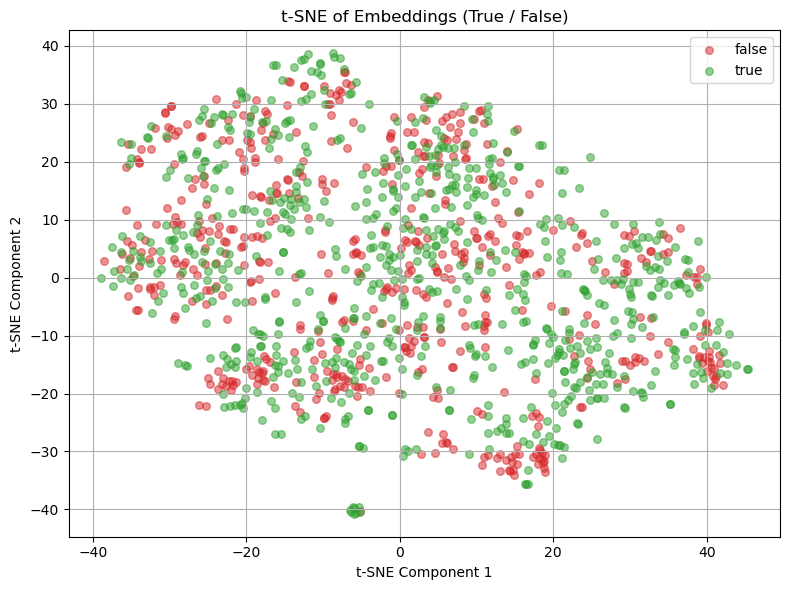

c:\Users\qqppq\anaconda3\envs\classifier_fusion\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


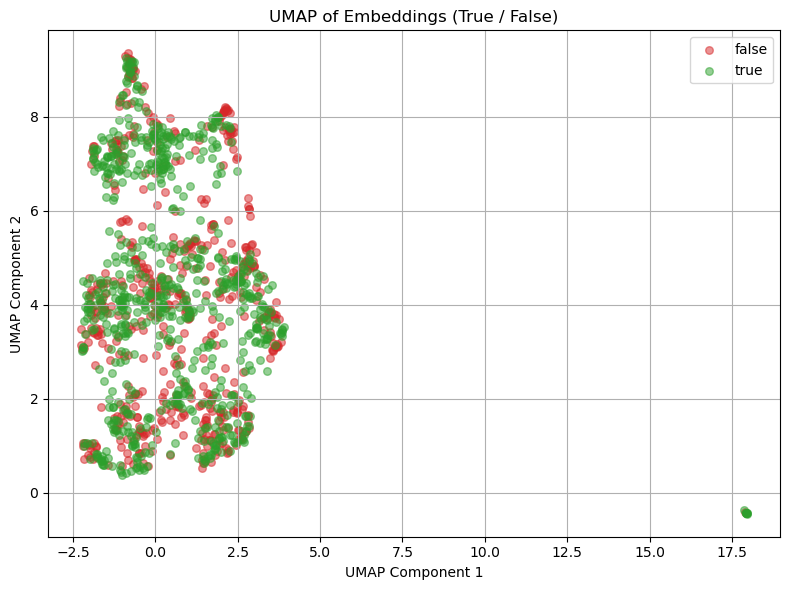

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler

# ------------------------------
# 데이터 통합
# ------------------------------
X_all = np.vstack([X_tr_scaled, X_va_scaled, X_te_scaled])
y_all = np.concatenate([y_tr, y_va, y_te])

# ------------------------------
# t-SNE 시각화
# ------------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("t-SNE of Embeddings (True / False)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# UMAP 시각화
# ------------------------------
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_all)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("UMAP of Embeddings (True / False)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
